In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder,MNIST
import os
from torchvision.transforms import Compose,Normalize,Resize,ToTensor
import numpy as np
import tqdm

In [3]:
class MaskedConv2D(nn.Conv2d):
    def __init__(self, mask_type, *args,**kwargs):
        super(MaskedConv2D,self).__init__(*args,**kwargs)
        self.mask_type = mask_type
        _,_,h,w = self.weight.size()
        self.mask = torch.zeros((h,w)).cuda()
        self.mask[:h //2,:] = 1.
        self.mask[h//2,:w//2] = 1.
        if mask_type == "B":
            self.mask[h//2,w//2] = 1.
    def forward(self,x):
        self.weight.data = self.weight.data * self.mask
        return super(MaskedConv2D,self).forward(x)
        

In [4]:
# m = MaskedConv2D("A",1,16,5)

# x = torch.randint(low=0,high=255,size=(8,1,32,32)).long()
# m(x.float())
# print(m.mask)


In [5]:
class PixelCNN(nn.Module):
    def __init__(self,num_layers=15, filt_size=5,inp_channels=1,num_fm=16):
        super(PixelCNN,self).__init__()
        first_layer = MaskedConv2D("A",inp_channels,num_fm,filt_size,padding=filt_size//2,bias=False) # padding to get same conv
        layers = [first_layer]
        for i in range(num_layers-1):
            layers.append(nn.ReLU())
            layers.append(MaskedConv2D("B",num_fm,num_fm,filt_size,padding=filt_size//2,bias=False))
        # 1x 1 conv to get logits
        last_layer = nn.Conv2d(num_fm,256,1)
        layers.append(last_layer)
        self.layers = nn.Sequential(*layers)
        
    def forward(self,x):
        # no softmax cuz it gets combined in loss
        return self.layers(x)
        
    

In [6]:
# tr = DataLoader(MNIST('../data', train=True, download=True, transform=ToTensor()),
#                      batch_size=128, shuffle=True, num_workers=1, pin_memory=True)

# pcnn = PixelCNN().cuda()
# h,w = 28,28

# opt = Adam(pcnn.parameters(),lr=0.01)

# for epoch in range(5):
#     t = tqdm.tqdm(tr)
#     for x,y in t:
#         opt.zero_grad()
#         x = x.cuda()
#         x_tild = pcnn(x)
#         loss= F.cross_entropy(x_tild,x.long().squeeze())
#         loss.backward()
#         opt.step()
#         t.set_description("epoch:%iloss:%6.4f"%(epoch,float(loss.data)))

# # x_tild = p(x.float())
# # x.size()

# # sampling
# sample = torch.zeros((1,1,h,w)).cuda()


# for i in range(h):
#     for j in range(w):
#         s_tild = pcnn(sample)
#         probs = F.softmax(s_tild,dim=1)[0,:,i,j]
#         sample[:,0,i,j] = torch.multinomial(probs,1)
        

# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.imshow(sample[0,0],cmap="gray")

In [71]:
class VMaskedConv2D(nn.Conv2d):
    def __init__(self,*args,**kwargs):
        super(VMaskedConv2D,self).__init__(*args,**kwargs)
        _,_,h,w = self.weight.size()
        self.mask = torch.zeros((h,w)).cuda()
        self.mask[:h //2,:] = 1.
    def forward(self,x):
        self.weight.data = self.weight.data * self.mask
        return super(VMaskedConv2D,self).forward(x)
    

In [72]:
# vm = VMaskedConv2D(1,16,5)

# x = torch.randint(low=0,high=255,size=(8,1,32,32)).long()
#print(vm.mask)
# vm(x.float())

In [73]:
class HMaskedConv2D(nn.Conv2d):
    def __init__(self,mask_type,*args,**kwargs):
        super(HMaskedConv2D,self).__init__(*args,**kwargs)
        _,_,h,w = self.weight.size()
        self.mask = torch.zeros((h,w)).cuda()
        self.mask[h //2,:w//2] = 1.
        if mask_type == "B":
            self.mask[h //2,:w//2+1] = 1.
            
    def forward(self,x):
        self.weight.data = self.weight.data * self.mask
        return super(HMaskedConv2D,self).forward(x)

In [74]:
# hm = HMaskedConv2D("A",1,16,5)

# hm.mask

#x = torch.randint(low=0,high=255,size=(8,1,32,32))

#hm(x)

In [75]:
class GatedLayer(nn.Module):
    def __init__(self,in_channels,out_channels,filter_size,mask_type,cond_size,skip_cxn=False):
        super(GatedLayer,self).__init__()
        self.out_channels = out_channels
        self.vconv = VMaskedConv2D(in_channels,2*out_channels,filter_size,padding=filter_size//2,bias=False)
        self.hconv = HMaskedConv2D(mask_type,in_channels,2*out_channels,filter_size,padding=filter_size//2,bias=False)
        self.cond_embed = nn.Linear(cond_size, 2*out_channels)
        self.v2h_conv1x1 = nn.Conv2d(2*out_channels,2*out_channels,1)
        self.skip_conv1x1 = nn.Conv2d(out_channels,out_channels,1)
        self.skip_cxn = skip_cxn
    def forward(self,x_v,x_h,y):
        #y is the conditioning
        vc2p = self.vconv(x_v)
        vcf, vcg = torch.split(vc2p,self.out_channels,dim=1)
        y = self.cond_embed(y)
        yf,yg = torch.split(y,self.out_channels,dim=1)
        #broadcast conditioning vector to all pixels
        fv = F.tanh(vcf + yf[:,:,None,None] )
        gv = F.sigmoid(vcg + yg[:,:,None,None] )
        vout = fv * gv
        
        
        hc2p = self.hconv(x_h) + self.v2h_conv1x1(vc2p)
        hcf, hcg = torch.split(hc2p,self.out_channels,dim=1)
        fh = F.tanh(hcf + yf[:,:,None,None] )
        gh = F.sigmoid(hcg + yg[:,:,None,None] )
        hout = fh * gh
        if self.skip_cxn:
            hout  = self.skip_conv1x1(hout) + x_h
            
        return vout,hout

        


In [76]:
# gl = GatedLayer(1,8,5,"A",3,skip_cxn=True)

# x = torch.randint(low=0,high=255,size=(8,1,32,32))

# y = torch.randint(low=0,high=512,size=(8,3))

# v,h = gl(x,x,y)

# gl2 = GatedLayer(8,8,5,"B",3,skip_cxn=True)

# gl2(v,h,y)

In [87]:
class GatedPixelCNN(nn.Module):
    def __init__(self,num_layers=15, filt_size=5,in_channels=1,
                 num_fm=16,cond_size=3,im_range=256):
        
        super(GatedPixelCNN,self).__init__()
        self.first_layer = GatedLayer(in_channels=in_channels,out_channels=num_fm,
                                 filter_size=filt_size,mask_type="A",cond_size=3,skip_cxn=True)
        layers = []
        for i in range(num_layers - 1):
            layers.append(GatedLayer(in_channels=num_fm,out_channels=num_fm,
                                 filter_size=filt_size,mask_type="B",cond_size=3,skip_cxn=True))
        self.layers = nn.Sequential(*layers)
           
        self.last_layer = nn.Conv2d(num_fm,im_range,1)
            
    def forward(self,x,y):
        xv,xh = self.first_layer(x,x,y)
        for layer in self.layers:
            xv,xh = layer(xv,xh,y)
        return self.last_layer(xh)
    
        
        
            
        
        
        

In [78]:
x = torch.randint(low=0,high=512,size=(8,1,21,21))

y = torch.randint(low=0,high=512,size=(8,3))

In [79]:
gpcnn = GatedPixelCNN(im_range=512)

In [80]:
#gpcnn(x,y)

In [95]:
gpcnn = GatedPixelCNN(im_range=512).cuda()

h,w = 21,21

opt = Adam(gpcnn.parameters(),lr=0.001)
xs = torch.randint(low=0,high=512,size=(10,8,1,21,21)).cuda()
ys = torch.randint(low=0,high=512,size=(10,8,3)).cuda()

for epoch in range(5):
    losses = []
    for i in range(10):
        x = xs[i]
        y = ys[i]

        opt.zero_grad()
        x_tild = gpcnn(x,y)
        loss= F.cross_entropy(x_tild,x.long().squeeze())
        loss.backward()
        opt.step()
        losses.append(float(loss.data))
    print(np.mean(losses))

358.278204346
291.500866699
236.657679749
189.84723053
148.577581787


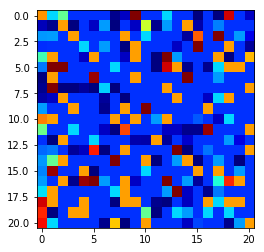

In [99]:
sample = torch.zeros((1,1,h,w)).cuda()
y = ys[0][0][None,:]
for i in range(h):
    for j in range(w):
        # calc unnormalized p(x_ij|x<) logits
        pxij_logit = gpcnn(sample,y)[0,:,i,j]
        
        # compute normalized p(x_ij|x<) 
        pxij = F.softmax(pxij_logit,dim=0)
        # sample from p(x_ij|x<)
        sample[:,0,i,j] = torch.multinomial(pxij,1)
        

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sample[0,0],cmap="jet")